In [1]:
import json
import pandas as pd
import math
import matplotlib.pyplot as plt
import PIL
import wandb

In [2]:
dataset = "test"
with open(f"/opt/ml/PieChartOcr/data/piedata/pie/annotations/instancesPie(1008)_{dataset}2019.json", "r") as f:
    test_json = json.load(f)

inference_data = "/opt/ml/PieChartOcr/test_data_save.json"
with open(inference_data, "r") as f:
    inference_json = json.load(f)

In [3]:
def ekey(x):
    return x[0]

def return_degree(groups):
    data_rs = []
    for group in groups:
        center_x = group[0][0]
        center_y = group[0][1]
        left_x = group[2][0]
        left_y = group[2][1]
        right_x = group[1][0]
        right_y = group[1][1]
        x1 = left_x - center_x
        y1 = left_y - center_y
        x2 = right_x - center_x
        y2 = right_y - center_y
        theta = math.degrees(math.acos(
            max(min((x1 * x2 + y1 * y2) / math.sqrt(x1 * x1 + y1 * y1) / math.sqrt(x2 * x2 + y2 * y2), 1), -1)))
        cross = x1 * (y2) - x2 * (y1)
        if cross < 0: # 180도 넘으면
            theta = 360 - theta
        theta_y = math.degrees(math.acos((-y1 / math.sqrt(x1 * x1 + y1 * y1))))
        if x1 < 0:
            theta_y = 360 - theta_y
        data_rs.append([theta_y, theta, group])
    data_rs.sort(key=ekey)
    theta_rtn, group_rtn = [], []
    for datum in data_rs:
        theta_rtn.append(datum[1])
        group_rtn.append(datum[2])
    return theta_rtn, group_rtn

test [[175.0, 127.0], [199.0, 198.0], [175.0, 52.0]]
inference [[172.5131072998047, 127.84829711914062], [196.88327026367188, 200.09425354003906], [172.9761962890625, 50.58843994140625], 0.6912785967191061]
test [[171.0, 129.0], [96.0, 121.0], [195.0, 200.0]]
inference [[172.5131072998047, 127.84829711914062], [95.79783630371094, 118.76084899902344], [196.88327026367188, 200.09425354003906], 0.6972565650939941]
test [[171.0, 126.0], [171.0, 51.0], [96.0, 118.0]]
inference [[172.5131072998047, 127.84829711914062], [172.9761962890625, 50.58843994140625], [95.79783630371094, 118.76084899902344], 0.7491539716720581]
test 45 inference 45
test 32 inference 33
test 24 inference 24


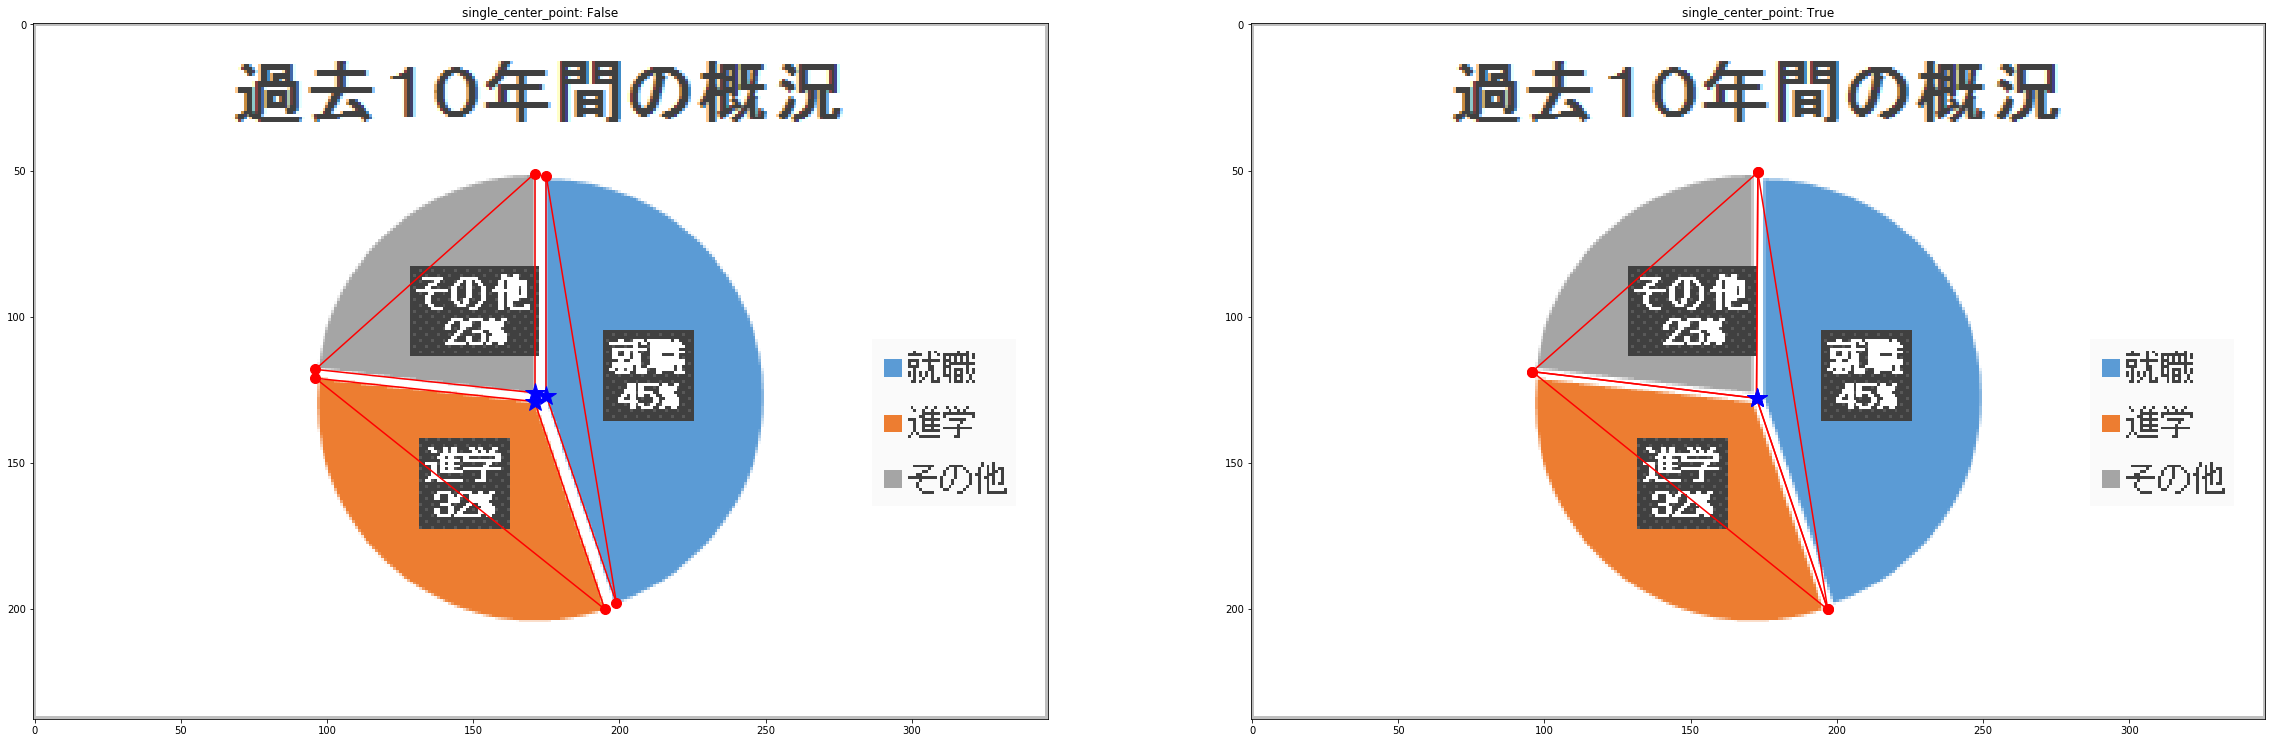

In [13]:
idx = 1740
df_images = pd.DataFrame(test_json["images"])
df_anno = pd.DataFrame(test_json['annotations'])
image_id = df_images.iloc[idx]["id"]
annotations = df_anno[df_anno["image_id"] == image_id]
file_name = df_images.iloc[idx]["file_name"]

inference_degrees = inference_json[file_name][0]
inference_groups = inference_json[file_name][1]

temp_groups = []
for key_points_idx in range(len(annotations)):
    key_points = annotations["bbox"].iloc[key_points_idx]
    x1,y1, x2,y2, x3,y3 = key_points
    temp_groups.append([[x3,y3], [x2,y2], [x1,y1]])

test_degrees, test_groups = return_degree(temp_groups)
for test_group, inference_group in zip(test_groups, inference_groups):
    print("test", test_group)
    print("inference", inference_group)
for test_degree, inference_degree in zip(test_degrees, inference_degrees):
    # print("test", test_degree, "inference", inference_degree)
    print("test", math.ceil(float(test_degree)/360*100), "inference", math.ceil(float(inference_degree)/360*100))


image_root = f"/opt/ml/PieChartOcr/data/piedata/pie/images/{dataset}2019/"
image_path = image_root + file_name

PIL_image = PIL.Image.open(image_path)

fig, ax = plt.subplots(1,2,figsize=(40,80))
ax[0].imshow(PIL_image)
test_center_point, test_single_center = None, True
for key_points_idx in range(len(annotations)):
    key_points = annotations["bbox"].iloc[key_points_idx]
    x1,y1, x2,y2, x3,y3 = key_points
    if test_center_point is None:
        test_center_point = (x3, y3)
    else:
        if test_center_point != (x3, y3):
            test_single_center = False
    
    # line
    ax[0].plot([x1,x2],[y1,y2],'-r')
    ax[0].plot([x2,x3],[y2,y3],'-r')
    ax[0].plot([x3,x1],[y3,y1],'-r')
    
    # scatter
    ax[0].plot(x1,y1,'or',markersize=10)
    ax[0].plot(x2,y2,'or',markersize=10)
    
    # center_point
    ax[0].plot(x3,y3,'*b',markersize=20)
ax[0].set_title(f"single_center_point: {test_single_center}")
ax[1].imshow(PIL_image)
inference_center_point, inference_single_center = None, True
for key_points in inference_groups:
    center_x = key_points[0][0]
    center_y = key_points[0][1]
    left_x = key_points[2][0]
    left_y = key_points[2][1]
    right_x = key_points[1][0]
    right_y = key_points[1][1]

    if inference_center_point is None:
        inference_center_point = (center_x, center_y)
    else:
        if inference_center_point != (center_x, center_y):
            inference_single_center = False
    
    # line
    ax[1].plot([left_x, right_x],[left_y,right_y],'-r')
    ax[1].plot([right_x,center_x],[right_y,center_y],'-r')
    ax[1].plot([center_x,left_x],[center_y,left_y],'-r')
    
    # scatter
    ax[1].plot(left_x, left_y,'or',markersize=10)
    ax[1].plot(right_x,right_y,'or',markersize=10)
    
    # center_point
    ax[1].plot(center_x,center_y, '*b',markersize=20)
ax[1].set_title(f"single_center_point: {inference_single_center}")

plt.show()

In [6]:
# Run = wandb.init(
#     entity="passion-ate",
#     project="Error-visualization",
#     name=f"first-gt"
# )

In [89]:
image_root = f"/opt/ml/PieChartOcr/data/piedata/pie/images/test2019/"
df_images = pd.DataFrame(test_json["images"])
df_anno = pd.DataFrame(test_json['annotations'])
losses = 0
degree_losses = 0
error = 0
error_list = []
degree_zero = []

for idx in range(1923):
    loss = 0
    deg_loss = 0
    image_id = df_images.iloc[idx]["id"]
    annotations = df_anno[df_anno["image_id"] == image_id]
    file_name = df_images.iloc[idx]["file_name"]
    image_path = image_root + file_name
    
    inference_degrees = inference_json[file_name][0]
    inference_groups = inference_json[file_name][1]

    temp_groups = []
    for key_points_idx in range(len(annotations)):
        key_points = annotations["bbox"].iloc[key_points_idx]
        x1,y1, x2,y2, x3,y3 = key_points
        temp_groups.append([[x3,y3], [x2,y2], [x1,y1]])

    test_degrees, test_groups = return_degree(temp_groups)
    len_test_degrees = len(test_degrees)
    len_inference_degrees = len(inference_degrees)
    if len_test_degrees == len_inference_degrees:
        for test_degree, inference_degree in zip(test_degrees, inference_degrees):
            loss+=(test_degree - inference_degree)
            deg_loss += (math.ceil(float(test_degree)/360*100) - math.ceil(float(inference_degree)/360*100))
        if len_test_degrees>0:
            losses += loss/len_test_degrees
            degree_losses += deg_loss/len_test_degrees
        else:
            degree_zero.append(file_name)
    else:
        error+=1
        error_list.append(file_name)
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    ax.imshow(PIL_image)
    center_point, single_center = None, True
    for key_points_idx in range(len(annotations)):
        key_points = annotations["bbox"].iloc[key_points_idx]
        x1,y1, x2,y2, x3,y3 = key_points
        if center_point is None:
            center_point = (x3, y3)
        else:
            if center_point != (x3, y3):
                single_center = False
    
    # line
    ax.plot([x1,x2],[y1,y2],'-r')
    ax.plot([x2,x3],[y2,y3],'-r')
    ax.plot([x3,x1],[y3,y1],'-r')
    
    # scatter
    ax.plot(x1,y1,'or',markersize=10)
    ax.plot(x2,y2,'or',markersize=10)
    
    # center_point
    ax.plot(x3,y3,'*b',markersize=20)

plt.show()
    
print(losses/1923)
print(degree_losses/1923)
print(error)
# print(error_list)

0.045222380080536674
0.00485805913591446
487


In [ ]:
image_root = f"/opt/ml/PieChartOcr/data/piedata/pie/images/test2019/"
df_images = pd.DataFrame(test_json["images"])
df_anno = pd.DataFrame(test_json['annotations'])
losses = 0
degree_losses = 0
error = 0
error_list = []
degree_zero = []

for idx in range(1923):
    loss = 0
    deg_loss = 0
    image_id = df_images.iloc[idx]["id"]
    annotations = df_anno[df_anno["image_id"] == image_id]
    file_name = df_images.iloc[idx]["file_name"]
    image_path = image_root + file_name
    
    inference_degrees = inference_json[file_name][0]
    inference_groups = inference_json[file_name][1]

    temp_groups = []
    for key_points_idx in range(len(annotations)):
        key_points = annotations["bbox"].iloc[key_points_idx]
        x1,y1, x2,y2, x3,y3 = key_points
        temp_groups.append([[x3,y3], [x2,y2], [x1,y1]])

    test_degrees, test_groups = return_degree(temp_groups)
    len_test_degrees = len(test_degrees)
    len_inference_degrees = len(inference_degrees)
    if len_test_degrees == len_inference_degrees:
        for test_degree, inference_degree in zip(test_degrees, inference_degrees):
            loss+=(test_degree - inference_degree)
            deg_loss += (math.ceil(float(test_degree)/360*100) - math.ceil(float(inference_degree)/360*100))
        if len_test_degrees>0:
            losses += loss/len_test_degrees
            degree_losses += deg_loss/len_test_degrees
        else:
            degree_zero.append(file_name)
    else:
        error+=1
        error_list.append(file_name)
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    ax.imshow(PIL_image)
    center_point, single_center = None, True
    for key_points_idx in range(len(annotations)):
        key_points = annotations["bbox"].iloc[key_points_idx]
        x1,y1, x2,y2, x3,y3 = key_points
        if center_point is None:
            center_point = (x3, y3)
        else:
            if center_point != (x3, y3):
                single_center = False
    
    # line
    ax.plot([x1,x2],[y1,y2],'-r')
    ax.plot([x2,x3],[y2,y3],'-r')
    ax.plot([x3,x1],[y3,y1],'-r')
    
    # scatter
    ax.plot(x1,y1,'or',markersize=10)
    ax.plot(x2,y2,'or',markersize=10)
    
    # center_point
    ax.plot(x3,y3,'*b',markersize=20)

plt.show()
    
print(losses/1923)
print(degree_losses/1923)
print(error)
# print(error_list)

In [91]:
len(degree_zero)

57